In [1]:
import torch
from data_util import toDeviceDataLoader, load_cifar, to_device, load_mnist
from model_util import VGG
import torchvision
from util import dsa
from tqdm.notebook import tqdm
import torch.nn.functional as F
from matplotlib import pyplot as plt
import statsmodels.api as sm
import scipy
import numpy as np
import random

#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

torch.manual_seed(123)
random.seed(123)
np.random.seed(123)

In [2]:
class MNet(torch.nn.Module):
    def __init__(self):
        super(MNet, self).__init__()
        self.l1 = torch.nn.Linear(28*28, 100)
        self.l2 = torch.nn.Linear(100, 50)
        self.l3 = torch.nn.Linear(50, 10)
    
    def forward(self, x):
        out = torch.relu(self.l1(x))
        out = torch.relu(self.l2(out))
        return self.l3(out)

mdl = to_device(MNet(), device)
mdl.load_state_dict(torch.load('./models/torch_mnist_net.pth'))
mdl = mdl.eval()

# mdl = to_device(MNet(), device)
# crit = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(mdl.parameters(), lr=0.01) 
# for epoch in range(10):
#     pbar = tqdm(train_loader)
#     for batch_id, (images, labels) in enumerate(pbar):  
#         outputs = mdl(images.view(-1, 28*28))
#         loss = F.cross_entropy(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step() 
#         if batch_id == len(train_loader) - 1:
#             pbar.set_postfix({"Test Accuracy":dsa(test_loader, mdl)})
# torch.save(mdl.state_dict(), "models/torch_mnist_net.pth")

train_loader, test_loader = load_mnist(64, 10, device)
# mdl = to_device(VGG('VGG16'), device)
# mdl.load_state_dict(torch.load('./models/torch_cifar_vgg.pth'))
# mdl = mdl.eval()

# dataset_root = '/share/datasets/cifar10'
# cifar10_train, cifar10_val, cifar10_test = load_cifar(dataset_root)
# train_loader, val_loader, test_loader = toDeviceDataLoader(cifar10_train, cifar10_val, cifar10_test, device = device)

In [3]:
def tnmean_(alphas):
    less = - np.sqrt(2/np.pi) * torch.exp(-(alphas ** 2)/2) / (torch.erf(alphas/np.sqrt(2)) - 1)
    more = np.sqrt(2/np.pi) / torch.special.erfcx(alphas/np.sqrt(2))
    res = torch.where(alphas <= 0, less, more)
    return torch.max(alphas, res)

def tnmean(means, stds, mins):
    alphas = (mins - means)/stds
    return means + tnmean_(alphas) * stds

def tnmom2(alphas):
    return 1 + np.sqrt(2/np.pi) * alphas / torch.special.erfcx(alphas/np.sqrt(2))

def tnvar_(alphas):
    m1 = tnmean_(alphas)
    m2 = torch.sqrt(tnmom2(alphas))
    return (m2 - m1) * (m2 + m1)

def tnvar(means, stds, mins):
    alphas = (mins - means)/stds
    return tnvar_(alphas) * (stds ** 2)

def tnmv(means, stds, mins): # 448 µs ± 4.93 µs vs. 781 µs ± 2 µs
    alphas = (mins - means)/stds
    aerfcx = torch.special.erfcx(alphas/np.sqrt(2))
    aerf = torch.erf(alphas/np.sqrt(2))
    mean_adjs = torch.max(alphas, np.sqrt(2/np.pi) * torch.where(alphas <= 0, - torch.exp(-(alphas ** 2)/2)/(aerf - 1), 1/aerfcx))
    m2 = torch.sqrt(1 + np.sqrt(2/np.pi) * alphas / aerfcx)
    var_adjs = (m2 - mean_adjs)/(m2 + mean_adjs)
    return torch.sum(means + mean_adjs * stds, dim = -1), torch.sum(var_adjs * (stds ** 2), dim = -1)

def gaussian_cdf(means, variances):
    return (1 + torch.erf(-means/(torch.sqrt(variances) * np.sqrt(2))))/2

In [4]:
class RectGaussianTensor:
    def __init__(self, means: torch.Tensor, variances: torch.Tensor, mins = None, maxs = None):
        self.batch_size = means.shape[0]
        if mins is None:
            self.num_gaussians = 1
            self.tensor_shape = means.shape[1:]
            self.means = means.unsqueeze(1)
            self.variances = variances.unsqueeze(1)
            self.mins = - torch.ones_like(self.means, device = means.device) * float("Inf")
            self.maxs = torch.ones_like(self.means, device = means.device) * float("Inf")
        else: 
            self.num_gaussians = means.shape[1]
            self.tensor_shape = means.shape[2:]
            self.means = means
            self.variances = variances
            self.mins = mins
            self.maxs = maxs

    def __repr__(self):
        return 'N({}, {}, {}, {})'.format(self.means, self.variances, self.mins, self.maxs)
    
    def __getitem__(self, key):
        return RectGaussianTensor(self.means[key: key + 1], self.variances[key: key + 1], self.mins[key: key + 1], self.maxs[key: key + 1])
    
    def __neg__(self):
        self.mins = - self.mins
        self.maxs = - self.maxs
        self.means = - self.means
    
    def __add__(self, other):
        if isinstance(other, self.__class__):
            return RectGaussianTensor(torch.cat((self.means, other.means)), torch.cat((self.variances, other.variances)), torch.cat((self.mins, other.mins)), torch.cat((self.maxs, other.maxs)))
        elif isinstance(other, (int, float)):
            return RectGaussianTensor(self.means + other, self.variances, self.mins + other, self.maxs + other)
        elif isinstance(other, torch.Tensor):
            assert other.shape == self.tensor_shape
            return RectGaussianTensor(self.means + other, self.variances, self.mins + other, self.maxs + other)
        else:
            raise TypeError(f"Unsupported operand type(s) for +/-: '{self.__class__}' and '{type(other)}'")
    __radd__ = __add__

    def __sub__(self, other):
        return self + -other
    def __rsub__(self, other):
        return -self + other
    
    def __mul__(self, other):
        if isinstance(other, (int, float, torch.Tensor)):
            return RectGaussianTensor(other * self.means, (other ** 2) * self.variances, other * self.mins, other * self.maxs)
        else:
            raise TypeError(f"Unsupported operand type(s) for *: '{self.__class__}' and '{type(other)}'")
    __rmul__ = __mul__

    def __matmul__(self, other):
        if isinstance(other, torch.Tensor):
            assert len(self.tensor_shape) == 1
            return sum([RectGaussianTensor(self.means[:,:,i:i+1] @ other[:,i].T, self.variances[:,:,i:i+1] @ (other[:,i] **2).T, self.mins[:,:,i:i+1] @ other[:,i].T, self.maxs[:,:,i:i+1] @ other[:,i].T) for i in range(self.tensor_shape[0])])
        else:
            raise TypeError(f"Unsupported operand type(s) for *: '{self.__class__}' and '{type(other)}'")
    
    def flatten(self):
        return RectGaussianTensor(self.means.view(self.batch_size, self.num_gaussians, -1), self.variances.view(self.batch_size, self.num_gaussians, -1), self.mins.view(self.batch_size, self.num_gaussians, -1), self.maxs.view(self.batch_size, self.num_gaussians, -1))
    
    def relu(self):
        return RectGaussianTensor(self.means, self.variances, torch.relu(self.mins), torch.relu(self.maxs))

In [5]:
class TruncGaussianPMTensor:
    def __init__(self, means: torch.Tensor, variances: torch.Tensor, mins = None, pm_sizes = None, pm_locs = None, pm_tot_sizes = None):
        self.batch_size = means.shape[0]
        self.tensor_shape = means.shape[1:]
        self.means = means
        if isinstance(variances, float):
            self.variances = variances * torch.ones_like(self.means, device = means.device)
        else:
            self.variances = variances
        if mins is None:
            self.mins = - torch.ones_like(self.means, device = means.device) * float("Inf")
            self.pm_sizes = torch.tensor([])
            self.pm_locs = torch.tensor([])
            self.pm_tot_sizes = torch.tensor([])
        else: 
            self.mins = mins
            self.pm_sizes = pm_sizes
            self.pm_locs = pm_locs
            self.pm_tot_sizes = pm_tot_sizes

    def __repr__(self):
        return 'N({}, {}, {}, {}, {})'.format(self.means, self.variances, self.mins, self.pm_sizes, self.pm_locs)
    
    def __getitem__(self, key):
        return TruncGaussianPMTensor(self.means[key: key + 1], self.variances[key: key + 1], self.mins[key: key + 1], self.pm_sizes[key: key + 1], self.pm_locs[key: key + 1], self.pm_tot_sizes[key: key + 1])
    
    def __neg__(self):
        self.mins = - self.mins
        self.maxs = - self.maxs
        self.means = - self.means
        self.pm_locs = - self.pm_locs
    
    def __add__(self, other):
        if isinstance(other, self.__class__):
            raise TypeError(f"Unsupported addition of two '{self.__class__}'")
        elif isinstance(other, (int, float)):
            return TruncGaussianPMTensor(self.means + other, self.variances, self.mins + other, self.pm_sizes, self.pm_locs + other if len(self.pm_locs) > 0 else self.pm_locs, self.pm_tot_sizes)
        elif isinstance(other, torch.Tensor):
            #assert other.shape == self.tensor_shape
            return TruncGaussianPMTensor(self.means + other, self.variances, self.mins + other, self.pm_sizes, self.pm_locs + other.view(1, other.shape[0], 1).repeat((self.batch_size, 1, self.pm_locs.shape[2])) if len(self.pm_locs) > 0 else self.pm_locs, self.pm_tot_sizes)
        else:
            raise TypeError(f"Unsupported operand type(s) for +/-: '{self.__class__}' and '{type(other)}'")
    __radd__ = __add__

    def __sub__(self, other):
        return self + -other
    def __rsub__(self, other):
        return -self + other
    
    def __mul__(self, other):
        if isinstance(other, (int, float, torch.Tensor)):
            raise NotImplementedError
            #return TruncGaussianPMTensor(other * self.means, (other ** 2) * self.variances, other * self.mins, self.pm_sizes, other * self.pm_locs, self.pm_tot_sizes)
        else:
            raise TypeError(f"Unsupported operand type(s) for *: '{self.__class__}' and '{type(other)}'")
    __rmul__ = __mul__

    def __matmul__(self, other):
        if isinstance(other, torch.Tensor):
            assert len(self.tensor_shape) == 1
            if torch.all(self.mins == - float("Inf")):
                return TruncGaussianPMTensor(self.means @ other.T, self.variances @ (other ** 2).T, - float("Inf") * torch.ones([self.batch_size, other.shape[0]], device = self.mins.device), self.pm_sizes, self.pm_locs, self.pm_tot_sizes)
            else:
                temp_means = torch.cat([(self.means[:,i:i+1] * other[:,i]).unsqueeze(2) for i in range(self.tensor_shape[0])], dim = 2)
                temp_variances = torch.cat([(self.variances[:,i:i+1] * (other[:,i] ** 2)).unsqueeze(2) for i in range(self.tensor_shape[0])], dim = 2)
                temp_mins = torch.cat([(self.mins[:,i:i+1] * other[:,i]).unsqueeze(2) for i in range(self.tensor_shape[0])], dim = 2)
                self.temp_means = temp_means
                self.temp_variances = temp_variances
                self.temp_mins = temp_mins
                means, variances = tnmv(temp_means, temp_variances, temp_mins)
                #print(temp_means.sum(dim = 2)[0,0])
                #print(means[0,0])
                mins = - float("Inf") * torch.ones_like(means)
                # if self.pm_sizes.shape[2] == 1:
                #     print('hi')
                #     return TruncGaussianPMTensor(means, variances, mins, self.pm_sizes, self.pm_locs, self.pm_tot_sizes)
                # else:
                pm_locs = torch.einsum('ijk, lj -> ilkj', self.pm_locs, other).reshape(self.batch_size, means.shape[1], -1)
                pm_sizes = self.pm_sizes.permute(0, 2, 1).unsqueeze(1).repeat(1, means.shape[1], 1, 1).reshape(self.batch_size, means.shape[1], -1)/self.tensor_shape[0]
                pm_tot_sizes = torch.sum(self.pm_tot_sizes, dim = 1, keepdim = True).repeat(1, means.shape[1])/self.tensor_shape[0]
                return TruncGaussianPMTensor(means, variances, mins, pm_sizes, pm_locs, pm_tot_sizes)
                #means = torch.cat([(self.means[:,i:i+1] * other[:,i]).unsqueeze(1) for i in range(self.tensor_shape[0])], dim = 1)
                #variances = torch.cat([(self.variances[:,i:i+1] * (other[:,i] ** 2)).unsqueeze(1) for i in range(self.tensor_shape[0])], dim = 1)
                #mins = torch.cat([(self.mins[:,i:i+1] * other[:,i]).unsqueeze(1) for i in range(self.tensor_shape[0])], dim = 1)
                #return TruncGaussianPMTensor(means, variances, mins, self.pm_sizes, self.pm_locs, self.pm_tot_sizes)

        else:
            raise TypeError(f"Unsupported operand type(s) for *: '{self.__class__}' and '{type(other)}'")
    
    def flatten(self):
        return TruncGaussianPMTensor(self.means.view(self.batch_size, -1), self.variances.view(self.batch_size, -1), self.mins.view(self.batch_size, -1), self.pm_sizes.view(self.batch_size, -1), self.pm_locs.view(self.batch_size, -1), self.tot_sizes)
    
    def relu(self):
        gcdf = gaussian_cdf(self.means, self.variances)
        if len(self.pm_sizes) == 0:
            pm_sizes = gcdf.unsqueeze(2)
            pm_locs = torch.zeros_like(pm_sizes)
            pm_tot_sizes = gcdf
        else:
            pm_pos_sizes = torch.where(self.pm_locs > 0, self.pm_sizes, 0)
            pm_neg_sizes = torch.where(self.pm_locs > 0, 0, self.pm_sizes)
            pm_zero = (torch.sum(pm_neg_sizes, dim = 2) + gcdf * (1 - self.pm_tot_sizes)).unsqueeze(2)
            pm_sizes = torch.cat((pm_pos_sizes, pm_zero), dim = 2)
            pm_locs = torch.cat((self.pm_locs, torch.zeros_like(pm_zero)), dim = 2)
            pm_tot_sizes = self.pm_tot_sizes + gcdf * (1 - self.pm_tot_sizes)
        return TruncGaussianPMTensor(self.means, self.variances, torch.relu(self.mins), pm_sizes, pm_locs, pm_tot_sizes)

    def sample(self, N):
        normals = torch.max(self.mins.unsqueeze(2).expand([*self.means.shape, N]), torch.sqrt(self.variances).unsqueeze(2).expand([*self.means.shape, N]) * torch.randn([*self.means.shape, N], device = self.means.device) + self.means.unsqueeze(2).expand([*self.means.shape, N]))
        if len(self.pm_sizes) == 0:
            return normals
        if torch.all(self.mins == -float('Inf')):
            fixed_pm_sizes = torch.cat((self.pm_sizes[:,:,:-1], torch.where(self.pm_sizes.sum(dim = 2) == 0, 1, self.pm_sizes[:,:,-1]).unsqueeze(2)), dim = 2)
            pm_tot_sizes = self.pm_tot_sizes
        else:
            if self.pm_sizes.shape[2] == 1:
                pm_tot_sizes = torch.zeros_like(self.pm_tot_sizes)
                fixed_pm_sizes = torch.ones_like(self.pm_sizes)
            else:
                gcdf = gaussian_cdf(self.means, self.variances)
                #pm_tot_sizes = self.pm_tot_sizes
                pm_tot_sizes = (self.pm_tot_sizes - gcdf)/(1-gcdf)
                adj_pm_sizes = torch.cat((self.pm_sizes[:,:,:-1], (self.pm_sizes[:,:,-1] - gcdf * (1 - pm_tot_sizes)).unsqueeze(2)), dim = 2)
                fixed_pm_sizes = torch.cat((adj_pm_sizes[:,:,:-1], torch.where(adj_pm_sizes.sum(dim = 2) == 0, 1, adj_pm_sizes[:,:,-1]).unsqueeze(2)), dim = 2)
        pm_idx = torch.multinomial(fixed_pm_sizes.reshape(-1, self.pm_sizes.shape[2]), N, replacement = True).reshape(self.batch_size, self.tensor_shape[0], -1)
        pms = self.pm_locs[torch.arange(self.batch_size).reshape(self.batch_size, 1, 1).repeat(1, self.tensor_shape[0], N), torch.arange(self.tensor_shape[0]).reshape(1, self.tensor_shape[0], 1).repeat(self.batch_size, 1, N), pm_idx]
        #gpm_ratio = torch.rand([*self.means.shape, N], device = self.means.device)
        #return torch.where(gpm_ratio > pm_tot_sizes.unsqueeze(2).expand([*self.means.shape, N]), normals, pms)
        return torch.sum((self.pm_sizes * self.pm_locs), dim = 2, keepdim = True).expand([*self.means.shape, N]) + normals * (1 - pm_tot_sizes.unsqueeze(2).expand([*self.means.shape, N]))


In [6]:
x, y = next(iter(train_loader))
x = x.view(-1, 28*28).to(device)

In [7]:
t = TruncGaussianPMTensor(means = x, variances = 0.1)
t1 = t @ mdl.l1.weight + mdl.l1.bias
t1r = t1.relu()
t2w = t1r @ mdl.l2.weight
t2 = t2w + mdl.l2.bias
t2r = t2.relu()
t3 = t2r @ mdl.l3.weight + mdl.l3.bias

In [16]:
def sample_mdl(mdl, x, variance, i, j, N = 10000, level = None):
    if level == '1w':
        print(((x + np.sqrt(variance) * torch.randn_like(x)) @ mdl.l1.weight.T).shape)
        return torch.tensor([((x + np.sqrt(variance) * torch.randn_like(x)) @ mdl.l1.weight.T)[i][j] for _ in range(N)])
    elif level == '1':
        return torch.tensor([((x + np.sqrt(variance) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias)[i][j] for _ in range(N)])
    elif level == '1r':
        return torch.tensor([torch.relu((x + np.sqrt(variance) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias)[i][j] for _ in range(N)])
    elif level == '2w':
        return torch.tensor([(torch.relu((x + np.sqrt(variance) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias) @ mdl.l2.weight.T)[i][j] for _ in range(N)])
    elif level == '2':
        return torch.tensor([(torch.relu((x + np.sqrt(variance) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias) @ mdl.l2.weight.T + mdl.l2.bias)[i][j] for _ in range(N)])
    elif level == '2r':
        return torch.tensor([torch.relu(torch.relu((x + np.sqrt(variance) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias) @ mdl.l2.weight.T + mdl.l2.bias)[i][j] for _ in range(N)])
    elif level == '3w':
        return torch.tensor([(torch.relu(torch.relu((x + np.sqrt(variance) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias) @ mdl.l2.weight.T + mdl.l2.bias) @ mdl.l3.weight.T)[i][j] for _ in range(N)])
    else:
        return torch.tensor([mdl(x + np.sqrt(variance) * torch.randn_like(x))[i][j] for i in range(N)])

In [163]:
t3_samples = t3.sample(10000)[0,0].cpu().detach()

In [160]:
n3_samples = torch.tensor([mdl(x + np.sqrt(0.1) * torch.randn_like(x))[0][0]  for i in range(10000)])

In [38]:
t2w_samples = t2w.sample(10000)[0,0].cpu().detach()

In [39]:
n2w_samples = torch.tensor([(torch.relu((x + np.sqrt(0.1) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias) @ mdl.l2.weight.T)[0,0] for i in range(10000)])

In [151]:
n2_samples = torch.tensor([(torch.relu((x + np.sqrt(0.1) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias) @ mdl.l2.weight.T + mdl.l2.bias )[0,1] for i in range(10000)])
t2_samples = t2.sample(10000)[0,1].cpu().detach()

In [90]:
n1_samples = torch.tensor([(torch.relu((x + np.sqrt(0.1) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias) @ mdl.l2.weight.T + mdl.l2.bias )[0,0] for i in range(10000)])
t1_samples = t2.sample(10000)[0,0].cpu().detach()

In [28]:
t1r.temp_variances.shape, t1r.temp_means.shape, t1r.temp_mins.shape

(torch.Size([64, 50, 100]),
 torch.Size([64, 50, 100]),
 torch.Size([64, 50, 100]))

In [29]:
test_samples = torch.max(torch.sqrt(t1r.temp_variances).unsqueeze(3).expand([*t1r.temp_variances.shape, 1000]) * torch.randn([*t1r.temp_means.shape, 1000]) + t1r.temp_means.unsqueeze(3).expand([*t1r.temp_variances.shape, 1000]), t1r.temp_mins.unsqueeze(3).expand([*t1r.temp_variances.shape, 1000]))

In [32]:
t1r.pm_tot_sizes.shape

torch.Size([64, 100])

In [44]:
gcdf = gaussian_cdf(t1r.means, t1r.variances)

In [49]:
torch.sum(test_samples, dim = 2)

torch.Size([64, 50, 1000])

In [45]:
test_samples_ = torch.sum(test_samples, dim = 2)[0][0] * (1 - gcdf.unsqueeze(2).expand([*t1r.pm_tot_sizes.shape, 1000]))

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1000.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([-0.5       , -0.46000001, -0.41999999, -0.38      , -0.34      ,
        -0.30000001, -0.25999999, -0.22      , -0.18000001, -0.14      ,
        -0.1       , -0.06      , -0.02      ,  0.02      ,  0.06      ,
         0.1       ,  0.14      ,  0.18000001,  0.22      ,  0.25999999,
         0.30000001,  0.34      ,  0.38      ,  0.41999999,  0.46000001,
         0.5       ]),
 <BarContainer object of 25 artists>)

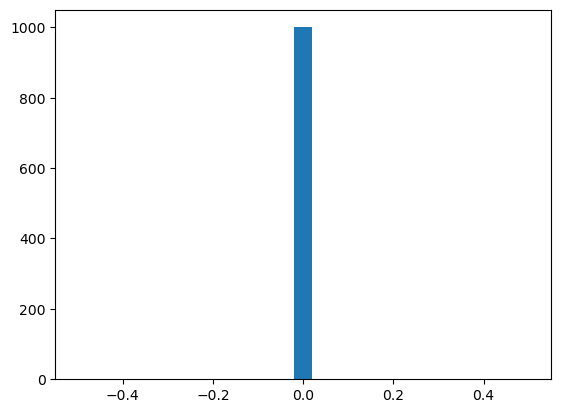

In [46]:
plt.hist(test_samples_.detach()[0][0], bins = 25)

In [87]:
t2.means[0,0]

tensor(718.1426, grad_fn=<SelectBackward0>)

In [170]:
torch.mean(t2_samples), torch.std(t2_samples)

(tensor(42.2199), tensor(5.0513))

In [169]:
torch.mean(n2_samples), torch.std(n2_samples)

(tensor(-85.8451), tensor(11.0737))

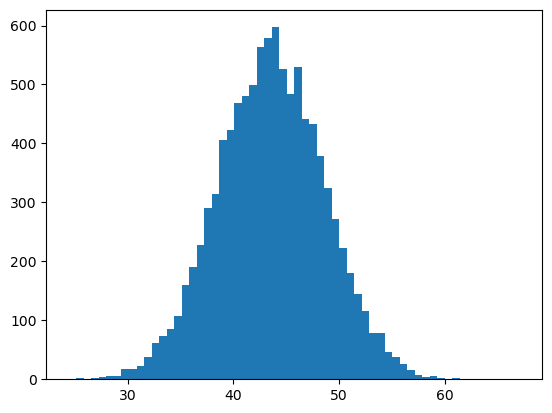

In [40]:
plt.hist(t2w_samples, bins = 60);

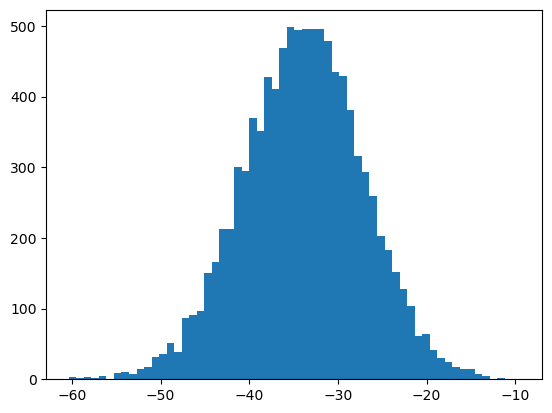

In [41]:
plt.hist(n2w_samples, bins = 60);
#plt.hist(t2_samples, bins = 60);

In [22]:
torch.argmax((((t1r.pm_sizes > 0.3) * (t1r.pm_sizes < 0.4)) + 1)[14,:], dim = 0)

tensor([42])

In [56]:
t1r.pm_sizes[15,73]

tensor([0.3218], grad_fn=<SelectBackward0>)

In [66]:
torch.sum(t1r_samples == 0), torch.sum(n1r_samples == 0)

(tensor(3208), tensor(3234))

In [23]:
n1r_samples = sample_mdl(mdl, x, 0.1, 14, 42, 10000, '1r')

In [24]:
t1r_samples = t1r.sample(10000)[14, 42].cpu().detach()

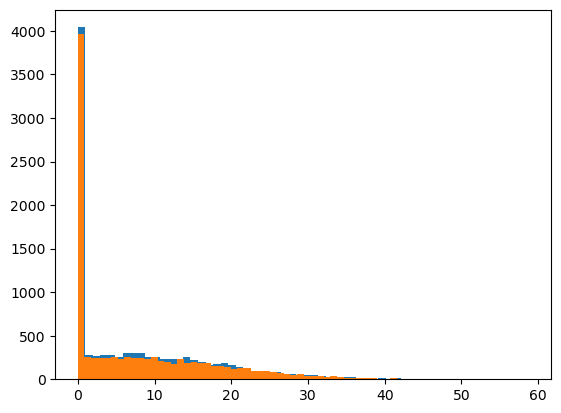

In [25]:
plt.hist(n1r_samples, bins = 60);
plt.hist(t1r_samples, bins = 60);

In [23]:
t1r.means[0,18]

tensor(93.2695, device='cuda:1', grad_fn=<SelectBackward0>)

In [10]:
gaussian_cdf(t1.means[0, 25], t1.variances[0, 25])

tensor(1., device='cuda:1', grad_fn=<DivBackward0>)

In [120]:
t1r.pm_tot_sizes[0,25]

tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)

In [226]:
ta = torch.tensor([[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]], [[16, 17, 18, 19, 20], [21, 22, 23, 24, 25], [26, 27, 28, 29, 30]]]) # [torch.tensor([[[1, 1, 1, 2, 3], [2, 4, 1, 2, 3], [0, 4, 3, 2, 1]], [[1, 4, 3, 2, 0], [1, 1, 2, 2, 3], [0, 1, 2, 3, 4]]])]

In [237]:
ta[[[0, 1], [0, 1]], [[1, 2], [0, 1]], [[2, 3], [0, 1]]]

tensor([[ 8, 29],
        [ 1, 22]])

In [231]:
idx = torch.multinomial(torch.ones((6, 5), dtype = torch.float), num_samples = 10, replacement = True).reshape(2, 3, -1)

In [240]:
idx = torch.multinomial(torch.ones((640, 3), dtype = torch.float), num_samples = 12, replacement = True).reshape(64, 10, -1)

In [243]:
torch.rand(64, 10, 100)[torch.arange(64).reshape(64, 1, 1).repeat(1, 10, 12), torch.arange(10).reshape(1, 10, 1).repeat(64, 1, 12), idx]

tensor([[[0.5980, 0.1220, 0.1220,  ..., 0.1220, 0.5980, 0.1948],
         [0.4625, 0.4625, 0.4625,  ..., 0.3585, 0.2253, 0.3585],
         [0.2492, 0.6261, 0.3214,  ..., 0.2492, 0.2492, 0.6261],
         ...,
         [0.7440, 0.8565, 0.8565,  ..., 0.7440, 0.7440, 0.7440],
         [0.1570, 0.1570, 0.1570,  ..., 0.7300, 0.7300, 0.7300],
         [0.4100, 0.8105, 0.4100,  ..., 0.4100, 0.4100, 0.9026]],

        [[0.3091, 0.3091, 0.3091,  ..., 0.3091, 0.1529, 0.1529],
         [0.6938, 0.6938, 0.8177,  ..., 0.8177, 0.1588, 0.1588],
         [0.7722, 0.7722, 0.7722,  ..., 0.4112, 0.0699, 0.7722],
         ...,
         [0.2943, 0.2943, 0.3927,  ..., 0.3790, 0.2943, 0.3927],
         [0.1151, 0.1151, 0.9310,  ..., 0.1151, 0.1151, 0.1151],
         [0.3759, 0.3759, 0.4595,  ..., 0.4595, 0.1353, 0.1353]],

        [[0.8478, 0.8478, 0.2941,  ..., 0.6054, 0.8478, 0.6054],
         [0.5746, 0.5746, 0.4745,  ..., 0.5746, 0.5746, 0.4745],
         [0.9483, 0.9483, 0.9483,  ..., 0.9483, 0.1970, 0.

In [162]:
a = torch.randn(100, 5, 35)

In [186]:
a.shape

torch.Size([100, 5, 35])

In [192]:
a.repeat((100, 1, 35)).shape

torch.Size([10000, 5, 1225])

In [165]:
a[a > 0]

torch.Size([8736])

In [161]:
torch.einsum('ijk, lj -> ilkj', torch.randn(10, 512, 33), torch.rand(100, 512)).shape

torch.Size([10, 100, 33, 512])

In [103]:
torch.sum(t1r[0].sample(10000), dim = 2).argmax()

tensor(25, device='cuda:0')

In [105]:
t1r_samples

tensor([[172.5999, 155.2319, 194.5272,  ..., 212.3552,   0.0000, 199.7285]])

In [90]:
n1r_samples

tensor([0., 0., 0.,  ..., 0., 0., 0.])

(array([1.676e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 6.000e+00,
        9.600e+01, 6.060e+02, 1.838e+03, 2.779e+03, 2.079e+03, 7.530e+02,
        1.490e+02, 1.600e+01]),
 array([  0.        ,  11.81116199,  23.62232399,  35.43348694,
         47.24464798,  59.05580902,  70.86697388,  82.6781311 ,
         94.48929596, 106.30045319, 118.11161804, 129.92277527,
        141.73394775, 153.54510498, 165.35626221, 177.16741943,
        188.97859192, 200.78974915, 212.60090637, 224.41207886,
        236.22323608]),
 <BarContainer object of 20 artists>)

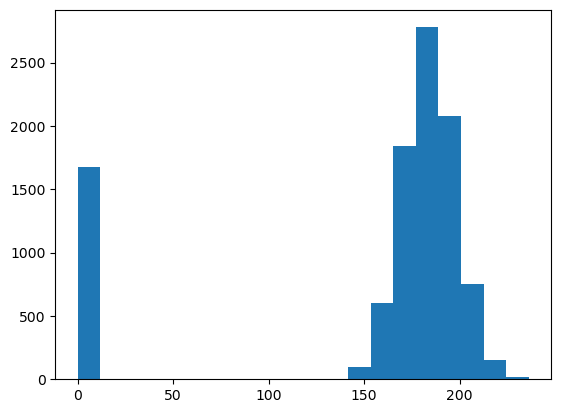

In [116]:
plt.hist(t1r_samples, bins = 20)

In [37]:
torch.all(t2r.pm_tot_sizes <= 1)

tensor(False, device='cuda:0')

In [107]:
n1r_samples = torch.tensor([torch.relu((x + np.sqrt(0.1) * torch.randn_like(x)) @ mdl.l1.weight.T + mdl.l1.bias)[0,25] for i in range(10000)])

In [73]:
t1r_samples.unique()

AttributeError: 'torch.Size' object has no attribute 'unique'

In [108]:
n1r_samples.unique()

tensor([131.6862, 136.8855, 137.3305,  ..., 232.9331, 233.1215, 247.7437])

(array([3.000e+00, 1.000e+01, 2.500e+01, 1.170e+02, 2.960e+02, 5.510e+02,
        9.840e+02, 1.372e+03, 1.643e+03, 1.699e+03, 1.362e+03, 9.780e+02,
        5.520e+02, 2.380e+02, 1.180e+02, 4.000e+01, 8.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00]),
 array([131.68617249, 137.48904419, 143.29191589, 149.09480286,
        154.89767456, 160.70054626, 166.50341797, 172.30628967,
        178.10917664, 183.91204834, 189.71492004, 195.51779175,
        201.32066345, 207.12355042, 212.92642212, 218.72929382,
        224.53216553, 230.33503723, 236.13792419, 241.9407959 ,
        247.7436676 ]),
 <BarContainer object of 20 artists>)

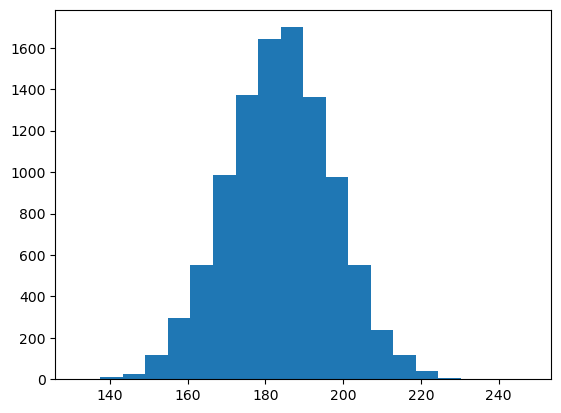

In [109]:
plt.hist(n1r_samples, bins = 20)

In [15]:
t1r.pm_sizes.shape

torch.Size([64, 100, 1])

In [13]:
t1r_samples = t1r[0].sample(1)

RuntimeError: invalid multinomial distribution (sum of probabilities <= 0)

In [50]:
N = 10000
rs_samples = torch.tensor([mdl(x + np.sqrt(0.1) * torch.randn_like(x))[0][0] for _ in range(N)])

In [24]:
frs_samples

torch.Size([10000])

In [48]:
sum(t3.sample(10000)[0,0].cpu().detach().numpy() > 0)

511

In [45]:
frs_samples = t3.sample(10000)[0,0].cpu().detach().numpy()

In [53]:
frs_samples.max()

2553778.2

(array([5.000e+00, 1.700e+01, 5.300e+01, 1.310e+02, 2.900e+02, 4.250e+02,
        8.100e+02, 1.178e+03, 1.365e+03, 1.491e+03, 1.357e+03, 1.122e+03,
        7.860e+02, 4.880e+02, 2.820e+02, 1.390e+02, 4.700e+01, 1.100e+01,
        1.000e+00, 2.000e+00]),
 array([-10.59793282, -10.32561684, -10.0532999 ,  -9.78098392,
         -9.50866699,  -9.23635101,  -8.96403503,  -8.6917181 ,
         -8.41940212,  -8.14708519,  -7.87476921,  -7.60245275,
         -7.3301363 ,  -7.05782032,  -6.78550386,  -6.51318741,
         -6.24087095,  -5.9685545 ,  -5.69623852,  -5.42392206,
         -5.15160561]),
 <BarContainer object of 20 artists>)

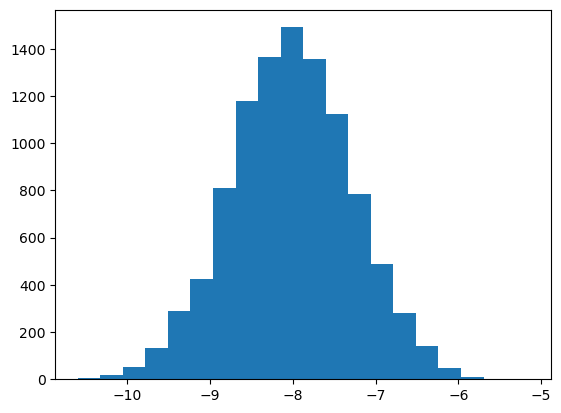

In [51]:
plt.hist(rs_samples, bins = 20)

(array([9.646e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 8.000e+00, 1.200e+01, 2.700e+01, 5.300e+01,
        7.000e+01, 5.600e+01, 6.100e+01, 2.800e+01, 2.100e+01, 1.200e+01,
        4.000e+00, 2.000e+00]),
 array([-4.27021205e-01,  1.27688508e+05,  2.55377438e+05,  3.83066375e+05,
         5.10755312e+05,  6.38444250e+05,  7.66133188e+05,  8.93822125e+05,
         1.02151106e+06,  1.14920000e+06,  1.27688888e+06,  1.40457788e+06,
         1.53226675e+06,  1.65995575e+06,  1.78764462e+06,  1.91533362e+06,
         2.04302250e+06,  2.17071150e+06,  2.29840050e+06,  2.42608925e+06,
         2.55377825e+06]),
 <BarContainer object of 20 artists>)

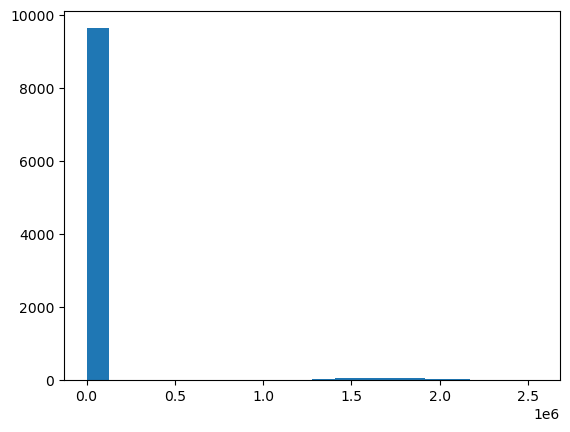

In [46]:
plt.hist(frs_samples, bins = 20)

In [203]:
t3.pm_sizes.shape

torch.Size([64, 10, 5050])

In [176]:
t1 = t @ mdl.l1.weight + mdl.l1.bias

In [10]:
t1r = t1.relu()

In [11]:
t2 = t1r @ mdl.l2.weight + mdl.l2.bias

In [127]:
torch.sum(torch.max(torch.normal(t2.means[0,:,0], t2.variances[0,:,0]), t2.mins[0,:,0]))/100

tensor(14.4128, device='cuda:0', grad_fn=<DivBackward0>)

In [12]:
def tnormal(means, variances, N = 10000):
    return torch.sqrt(variances).unsqueeze(3).expand([*means.shape, N]) * torch.randn([*means.shape, N], device = means.device) + means.unsqueeze(3).expand([*means.shape, N])

In [14]:
samples = tnormal(t2.means.cpu(), t2.variances.cpu())

In [27]:
samples_clip = torch.sum(torch.max(samples, t2.mins.unsqueeze(3).expand(64, 100, 50, 10000).cpu()), dim = 1).detach().numpy()

In [23]:
samples.shape

torch.Size([64, 100, 50, 10000])

In [26]:
samples_clip.shape

(100, 50, 10000)

In [58]:
res_fake = scipy.stats.normaltest(torch.randn(3200, 10000).numpy(), axis = 1)

In [59]:
min(res[1])

0.000460400852845522

In [60]:
res = scipy.stats.normaltest(samples_clip.reshape(-1, 10000), axis = 1)

In [50]:
scipy.stats.normaltest(samples_clip.reshape(-1, 10000)[1140,:])

NormaltestResult(statistic=258.84243753976506, pvalue=6.209817644988414e-57)

In [61]:
res[1].argmin()

1140

(array([330., 345., 338., 297., 295., 322., 309., 306., 339., 319.]),
 array([4.52821857e-05, 1.00029338e-01, 2.00013393e-01, 2.99997449e-01,
        3.99981504e-01, 4.99965560e-01, 5.99949615e-01, 6.99933671e-01,
        7.99917727e-01, 8.99901782e-01, 9.99885838e-01]),
 <BarContainer object of 10 artists>)

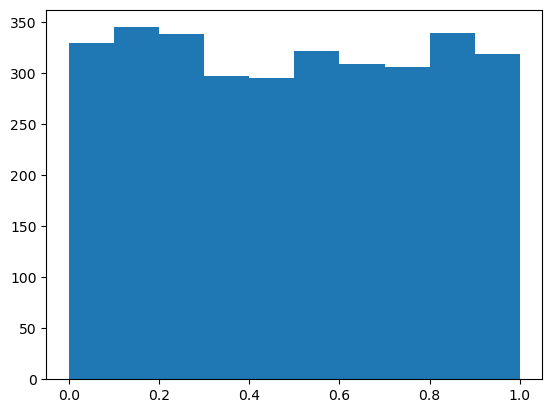

In [63]:
plt.hist(res_fake[1])

(array([420., 336., 326., 336., 305., 305., 277., 314., 280., 301.]),
 array([6.20962750e-57, 9.99663055e-02, 1.99932611e-01, 2.99898916e-01,
        3.99865222e-01, 4.99831527e-01, 5.99797833e-01, 6.99764138e-01,
        7.99730444e-01, 8.99696749e-01, 9.99663055e-01]),
 <BarContainer object of 10 artists>)

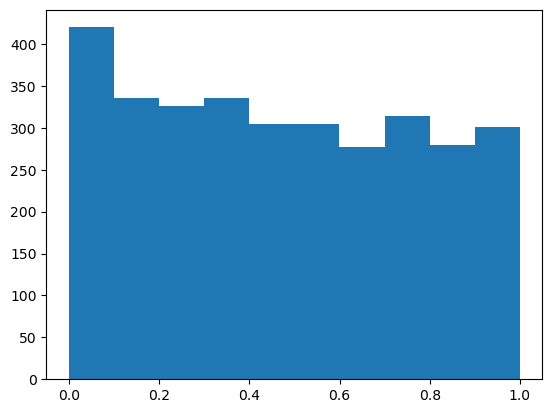

In [62]:
plt.hist(res[1])

In [155]:
def tnmean_(alphas):
    less = - np.sqrt(2/np.pi) * torch.exp(-(alphas ** 2)/2) / (torch.erf(alphas/np.sqrt(2)) - 1)
    more = np.sqrt(2/np.pi) / torch.special.erfcx(alphas/np.sqrt(2))
    res = torch.where(alphas <= 0, less, more)
    return torch.max(alphas, res)

def tnmean(means, stds, mins):
    alphas = (mins - means)/stds
    return means + tnmean_(alphas) * stds

def tnmom2(alphas):
    return 1 + np.sqrt(2/np.pi) * alphas / torch.special.erfcx(alphas/np.sqrt(2))

def tnvar_(alphas):
    m1 = tnmean_(alphas)
    m2 = torch.sqrt(tnmom2(alphas))
    return (m2 - m1) * (m2 + m1)

def tnvar(means, stds, mins):
    alphas = (mins - means)/stds
    return tnvar_(alphas) * (stds ** 2)

def tnmv(means, stds, mins): # 448 µs ± 4.93 µs vs. 781 µs ± 2 µs
    alphas = (mins - means)/stds
    aerfcx = torch.special.erfcx(alphas/np.sqrt(2))
    aerf = torch.erf(alphas/np.sqrt(2))
    mean_adjs = torch.max(alphas, np.sqrt(2/np.pi) * torch.where(alphas <= 0, - torch.exp(-(alphas ** 2)/2)/(aerf - 1), 1/aerfcx))
    m2 = torch.sqrt(1 + np.sqrt(2/np.pi) * alphas / aerfcx)
    var_adjs = (m2 - mean_adjs)/(m2 + mean_adjs)
    return torch.sum(means + mean_adjs * stds, dim = -1), torch.sum(var_adjs * (stds ** 2), dim = -1)


In [158]:
torch.sum(tnmean(t2.means, torch.sqrt(t2.variances), t2.mins), dim = 1)[0,0]

tensor(755.3978, device='cuda:0', grad_fn=<SelectBackward0>)

In [159]:
a, b = tnmv(t2.means.permute(0, 2, 1), torch.sqrt(t2.variances).permute(0, 2, 1), t2.mins.permute(0, 2, 1))

In [148]:
a.shape

torch.Size([64, 50])

In [160]:
a[0,0], b[0,0]

(tensor(755.3978, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(612.2227, device='cuda:0', grad_fn=<SelectBackward0>))

In [139]:
a.shape, b.shape

(torch.Size([64, 100]), torch.Size([64, 100]))

In [156]:
m, v = tnmv(t2.means[0,:,0], torch.sqrt(t2.variances[0,:,0]), t2.mins[0,:,0])

In [157]:
m, v

(tensor(755.3977, device='cuda:0', grad_fn=<SumBackward1>),
 tensor(612.2227, device='cuda:0', grad_fn=<SumBackward1>))

In [134]:
%%timeit
m, v = torch.sum(tnmean(t2.means[0,:,0], torch.sqrt(t2.variances[0,:,0]), t2.mins[0,:,0])), torch.sum(tnvar(t2.means[0,:,0], torch.sqrt(t2.variances[0,:,0]), t2.mins[0,:,0]))

781 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [111]:
m, v = m.cpu().detach().numpy(), v.cpu().detach().numpy()

In [72]:
torch.sum(t2.means[0,:,0])

tensor(94.4115, device='cuda:0', grad_fn=<SumBackward0>)

In [123]:
np.var(samples_clip[0, 0, :])

636.1627

In [121]:
np.mean(samples_clip[0, 0, :])

751.2478

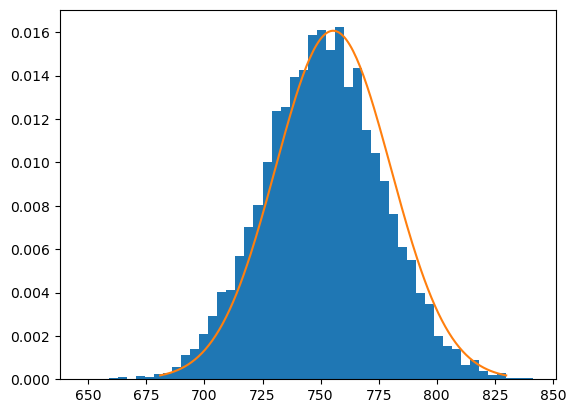

In [119]:
plt.hist(samples_clip.reshape(-1, 10000)[0,:], bins = 50, density = True)
x = np.linspace(m - 3*np.sqrt(v), m + 3*np.sqrt(v), 200)
plt.plot(x, scipy.stats.norm.pdf(x, m, np.sqrt(v)))

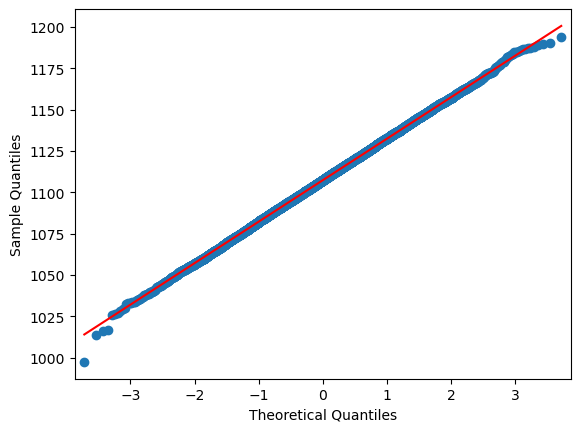

In [211]:
sm.qqplot(samples, line = 'q');

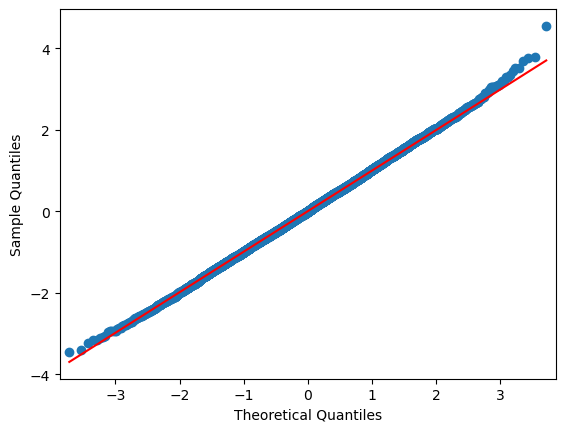

In [210]:
sm.qqplot(torch.randn(10000), line = 'q');

In [216]:
scipy.stats.jarque_bera(torch.randn(10000))

SignificanceResult(statistic=2.2368142636411448, pvalue=0.32679992946863196)

In [217]:
scipy.stats.jarque_bera(samples)

SignificanceResult(statistic=0.7646137209471207, pvalue=0.6822856545798848)